In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [ ]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    rt = 0
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt    
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1  
    return (rt+ndt)*ch

In [3]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    SBJ = np.array([])
    Cond = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta = prms['delta'].values[i]
        t0_sp = prms['t0_sp'].values[i]
        t0_ac = prms['t0_ac'].values[i]
        
        if model == 'exp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp * np.exp(-lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac * np.exp(-lamda_ac*t)
        elif model == 'hyp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp / (1 + lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac / (1 + lamda_ac*t)
        elif model == 'ddm':
            b0_sp = prms['b0_sp'].values[i]
            b0_ac = prms['b0_ac'].values[i]
            ub_sp = lambda t: b0_sp
            ub_ac = lambda t: b0_ac
            
        lb_sp = lambda t: -1*ub_sp(t)
        lb_ac = lambda t: -1*ub_ac(t)

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)

        rt = []
        cond = []

        for _ in range(300):
            cond.append('SP')
            rt.append(simulate_CDDM(ub_sp, lb_sp, delta, ndt=t0_sp))
            cond.append('AC')
            rt.append(simulate_CDDM(ub_ac, lb_ac, delta, ndt=t0_ac))

        RT = np.concatenate([RT, rt])
        Cond = np.concatenate([Cond, cond])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'cond':Cond,
                         'rt': np.abs(RT),
                         'accuracy': RT>0}) 

In [4]:
data = pd.read_csv('../../_Data/Study2.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data['Duration']<data['RT']].reset_index(drop=True)

data['RT']/=1000
data['Duration']/=1000

data_speed = data[data.cue == 'SP'].reset_index(drop=True)
data_accuracy = data[data.cue == 'AC'].reset_index(drop=True)

In [5]:
jhyp = pd.read_csv('_prms/hyp.csv')
jexp = pd.read_csv('_prms/exp.csv')
jddm = pd.read_csv('_prms/jddm.csv')
bhyp = pd.read_csv('_prms/bhyp.csv')
bexp= pd.read_csv('_prms/bexp.csv')
bddm= pd.read_csv('_prms/bddm.csv')

In [6]:
pred_jhyp = get_model_prediction(jhyp, data, 'hyp')

100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


In [7]:
pred_bhyp = get_model_prediction(bhyp, data, 'hyp')

100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


In [8]:
pred_jexp = get_model_prediction(jexp, data, 'exp')

100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


In [9]:
pred_bexp = get_model_prediction(bexp, data, 'exp')

100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


In [10]:
pred_jddm = get_model_prediction(jddm, data, 'ddm')

100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


In [11]:
pred_bddm = get_model_prediction(bddm, data, 'ddm')

100%|██████████| 25/25 [00:06<00:00,  3.97it/s]


In [12]:
def get_rt_acc_corr(pred):
    x = [pred[pred['accuracy']==True]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==True) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

def get_rt_acc_incorr(pred):
    x = [pred[pred['accuracy']==False]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==False) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

In [13]:
FONT_SIZE_1 = 20
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

COLOR_PALETTE = [
    "#286B4E", "#B32935"
]
DATA_ALPHA = 1.0
DATA_MARKER_SIZE = 200
PLOT_TITLES = ['HCT-DDM', 'ECT-DDM', 'FT-DDM']

PREDITOIN_LABLES = ['Prediction - Correct', 'Prediction - Incorrect']

In [14]:
def plot_data_speed():
    x = [data_speed[data_speed['correct']==1]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==1)&(data_speed['RT']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[0], marker='x', label='Data - Correct')
    ax.plot(x, y, c=COLOR_PALETTE[0], alpha=DATA_ALPHA)

    x = [data_speed[data_speed['correct']==0]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==0)&(data_speed['RT']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[1], marker='x', label='Data - Incorrect')
    ax.plot(x, y, c=COLOR_PALETTE[1], alpha=DATA_ALPHA)
    
def plot_data_accuracy():
    x = [data_accuracy[data_accuracy['correct']==1]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==1)&(data_accuracy['RT']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[0], marker='x', label='Data - Correct')
    ax.plot(x, y, c=COLOR_PALETTE[0], alpha=DATA_ALPHA)

    x = [data_accuracy[data_accuracy['correct']==0]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==0)&(data_accuracy['RT']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[1], marker='x', label='Data - Incorrect')
    ax.plot(x, y, c=COLOR_PALETTE[1], alpha=DATA_ALPHA)

### NDT-informed Prediction

In [23]:
predictions = [
    [get_rt_acc_corr(pred_jhyp[pred_jhyp['cond']=='SP']), get_rt_acc_incorr(pred_jhyp[pred_jhyp['cond']=='SP'])],
    [get_rt_acc_corr(pred_jexp[pred_jexp['cond']=='SP']), get_rt_acc_incorr(pred_jexp[pred_jexp['cond']=='SP'])],
    [get_rt_acc_corr(pred_jddm[pred_jddm['cond']=='SP']), get_rt_acc_incorr(pred_jddm[pred_jddm['cond']=='SP'])],
    [get_rt_acc_corr(pred_jhyp[pred_jhyp['cond']=='AC']), get_rt_acc_incorr(pred_jhyp[pred_jhyp['cond']=='AC'])],
    [get_rt_acc_corr(pred_jexp[pred_jexp['cond']=='AC']), get_rt_acc_incorr(pred_jexp[pred_jexp['cond']=='AC'])],
    [get_rt_acc_corr(pred_jddm[pred_jddm['cond']=='AC']), get_rt_acc_incorr(pred_jddm[pred_jddm['cond']=='AC'])],
]

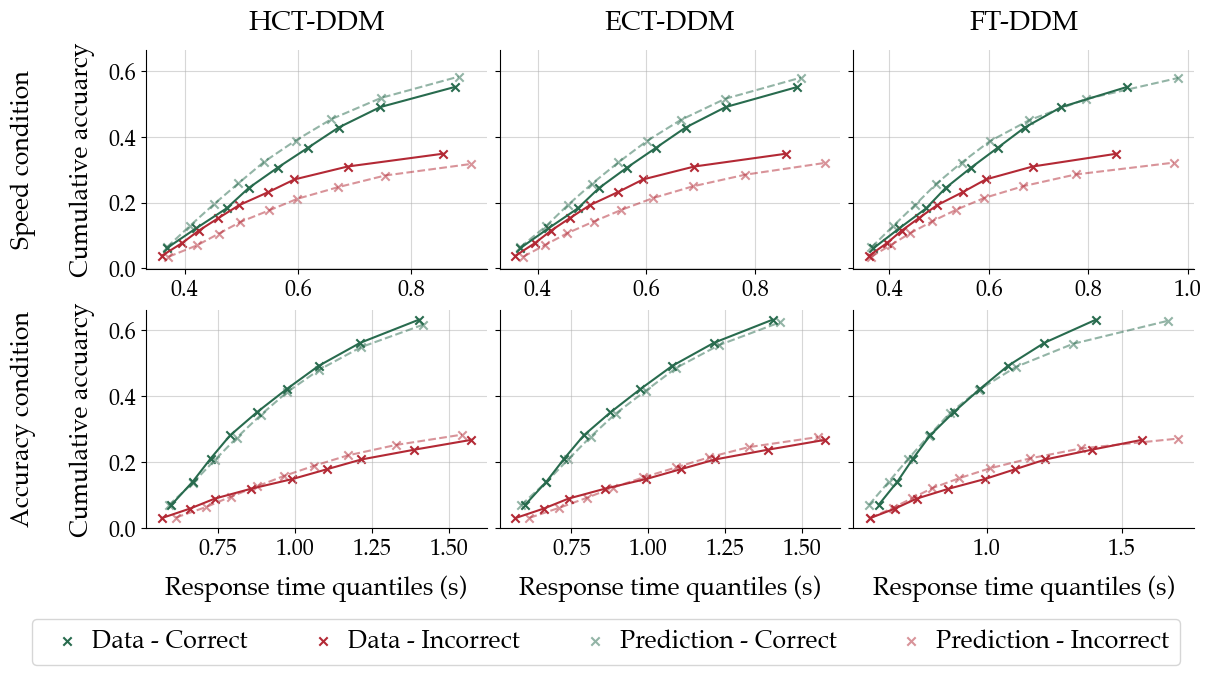

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained', sharey=True)
for i, ax in enumerate(axs.flat):
    # empirical data
    if i < 3:
        plot_data_speed()
        ax.set_title(PLOT_TITLES[i], fontsize=FONT_SIZE_1, pad=15)
    else:
        plot_data_accuracy()
        ax.set_xlabel('Response time quantiles (s)', fontsize=FONT_SIZE_2, labelpad=10)
    # predicted data
    for j in range(2):
        ax.scatter(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], marker='x', alpha=0.5,
            label=PREDITOIN_LABLES[j]
        )
        ax.plot(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], linestyle='--', alpha=0.5
        )
    if i == 0:
        ax.set_ylabel('Speed condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    if i == 3:
        ax.set_ylabel('Accuracy condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    
    ax.tick_params(labelsize=FONT_SIZE_3)
    ax.grid(alpha=0.5)
sns.despine()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='lower center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=4, fontsize=FONT_SIZE_2,
    handletextpad=0.
)
fig.savefig(
    '_plots/S2_preds_NDT_informed.pdf', 
    transparent=True,
    dpi=600,
    bbox_inches='tight'
)

### Uninformed Prediction

In [25]:
predictions = [
    [get_rt_acc_corr(pred_bhyp[pred_bhyp['cond']=='SP']), get_rt_acc_incorr(pred_bhyp[pred_bhyp['cond']=='SP'])],
    [get_rt_acc_corr(pred_bexp[pred_bexp['cond']=='SP']), get_rt_acc_incorr(pred_bexp[pred_bexp['cond']=='SP'])],
    [get_rt_acc_corr(pred_bddm[pred_bddm['cond']=='SP']), get_rt_acc_incorr(pred_bddm[pred_bddm['cond']=='SP'])],
    [get_rt_acc_corr(pred_bhyp[pred_bhyp['cond']=='AC']), get_rt_acc_incorr(pred_bhyp[pred_bhyp['cond']=='AC'])],
    [get_rt_acc_corr(pred_bexp[pred_bexp['cond']=='AC']), get_rt_acc_incorr(pred_bexp[pred_bexp['cond']=='AC'])],
    [get_rt_acc_corr(pred_bddm[pred_bddm['cond']=='AC']), get_rt_acc_incorr(pred_bddm[pred_bddm['cond']=='AC'])],
]

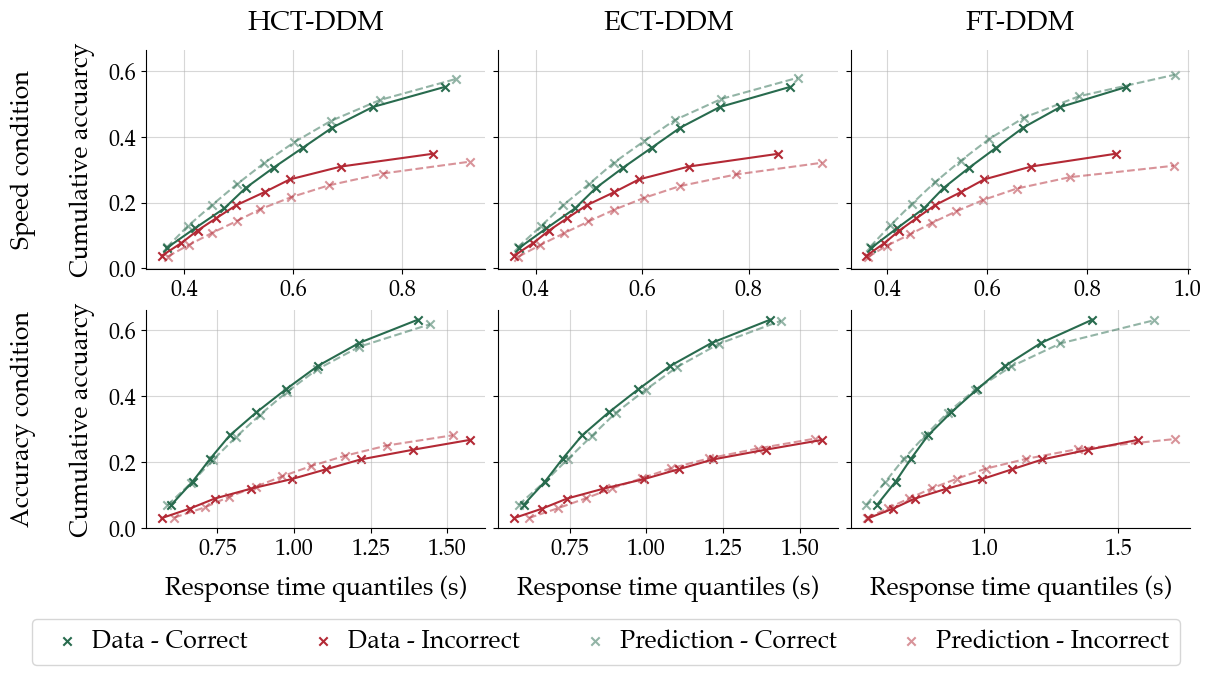

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained', sharey=True)
for i, ax in enumerate(axs.flat):
    # empirical data
    if i < 3:
        plot_data_speed()
        ax.set_title(PLOT_TITLES[i], fontsize=FONT_SIZE_1, pad=15)
    else:
        plot_data_accuracy()
        ax.set_xlabel('Response time quantiles (s)', fontsize=FONT_SIZE_2, labelpad=10)
    # predicted data
    for j in range(2):
        ax.scatter(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], marker='x', alpha=0.5,
            label=PREDITOIN_LABLES[j]
        )
        ax.plot(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], linestyle='--', alpha=0.5
        )
    if i == 0:
        ax.set_ylabel('Speed condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    if i == 3:
        ax.set_ylabel('Accuracy condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    
    ax.tick_params(labelsize=FONT_SIZE_3)
    ax.grid(alpha=0.5)
sns.despine()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='lower center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=4, fontsize=FONT_SIZE_2,
    handletextpad=0.
)
fig.savefig(
    '_plots/S2_preds_uninformed.pdf', 
    transparent=True,
    dpi=600,
    bbox_inches='tight'
)